## 03_MNE_preprocessing_EEG.ipynb
**What is preprocessing?**

Preprocessing is the term that EEG researchers use to describe "everything you have to do before you can analyze your dataset." EEG is electrical activity recorded from the scalp, and incredibly noisy/messy. A multitude of sources can influence the signal that this technology records: anything from the participant blinking to the electrical activity of the outlets in the room where you record! Preprocessing represents our best effort, as researchers, to truly isolate the neural data from all the other crap we recorded along the way.

**What is MNE?**

MNE is open-source software for preprocessing and analyzing EEG data (you can also analyze MEG, ECoG, and other types of data but we will use it for EEG here). You can read more about the project and find very good documentation on the software at this link: https://mne.tools/

In [1]:
import mne

#### Help! I am following along at home and the above line gave me an error
You need to install MNE via Anaconda: https://mne.tools/stable/install/index.html

If you have MNE installed and this still isn't working, you probably forgot to intialize the MNE conda environment before launching Jupyter Notebook. Exit out of Jupyter Notebook through your Terminal, then type `conda activate mne` and restart Jupyter Notebook.

If you are still having trouble then message Garret on Slack.

## Example dataset from onsetProd
onsetProd is the experiment that Garret analyzed for their Masters thesis. Garret is also the participant in this dataset!

The experiment itself consists of two types of trials: _production_, where participants read sentences aloud off an iPad; and _perception_, where participants listen to playback of themselves saying these sentences. Perception trials are also split into _predictable_ trials, where the playback they hear is what they just said; and _unpredictable_ trials, where instead they hear a randomly-selected previous trial instead. Code for analyzing onsetProd can be found in this repo: https://github.com/HamiltonLabUT/onsetProd

In [2]:
# The functions for loading EEG data can be found in the module mne.io
# If your data is a .vhdr file, use mne.io.read_raw_brainvision()
# If your data is a .fif file, use mne.io.read_raw_fif()
# YOU WILL NEED TO CHANGE THIS FILEPATH IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY!!!
file_path = '/Home/kfsh/Box/lab_intro_notebooks/data/example_raw_data.fif'
# the preload flag stores the data in memory, which makes manipulating it much faster. recommended!
raw = mne.io.read_raw_fif(file_path,preload=True)

Opening raw data file ./supplemental_files/data/example_raw_data.fif...


<ipython-input-2-49b5554e46c6>:6: RuntimeWarning: This filename (./supplemental_files/data/example_raw_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif(file_path,preload=True)


    Range : 0 ... 736914 =      0.000 ...  5757.141 secs
Ready.
Reading 0 ... 736914  =      0.000 ...  5757.141 secs...


In [3]:
# Data loaded using mne.io uses a custom data class, "Raw" to represent the dataset
raw
# 66 x 736915 is the number of channels by the number of samples (data points).

<Raw | example_raw_data.fif, 66 x 736915 (5757.1 s), ~371.2 MB, data loaded>

In [4]:
# What if we want to know more about the dataset we loaded? We can use raw.info
raw.info
# raw.info contains a bunch of dictionaries that contain additional info about the dataset

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG, 2 MISC
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: 2019-01-03 10:59:40 UTC
 meas_id: 4 items (dict)
 nchan: 66
 projs: []
 sfreq: 128.0 Hz
>

#### raw.info cheatsheet
* `raw.info['bads']` : the bad channels in the dataset
* `raw.info['ch_names']` : channel names
* `raw.info['chs']` : channel types. Different MNE functions care about different channel types
* `raw.info['custom_ref_applied']` : A reference is an electrode (or electrodes) that we subtract the activity of from other electrodes to help normalize the signal. You usually want to pick an electrode that is neutral, or does not have much neural activity. More on this later.
* `raw.info['dig']` : The locations of the channels within the montage. A montage is the location of the electrodes in space. I literally have never used this
* `raw.info['file_id']` and `raw.info['meas_id']` : Some sort of identifiers for the file. Literally never have used these either.
* `raw.info['highpass']` and `raw.info['lowpass']` : information about what filters have been applied
* `raw.info['meas_date']` : When the data was originally required. Wow, can't believe it's been two years since I started onsetProd.
* `raw.info['nchan']` : the number of channels
* `raw.info['projs']` : Projection vectors. We don't really use these in the Hamilton Lab as far as I know.
* `raw.info['sfreq']` : The sampling frequency of the data. We record raw data in 25kHz then downsample to 128Hz. Downsampling is possible through MNE but we do it in the recording software so I didn't include how to do that in this tutorial.

Play around printing out these different keys from the `raw.info` dict!

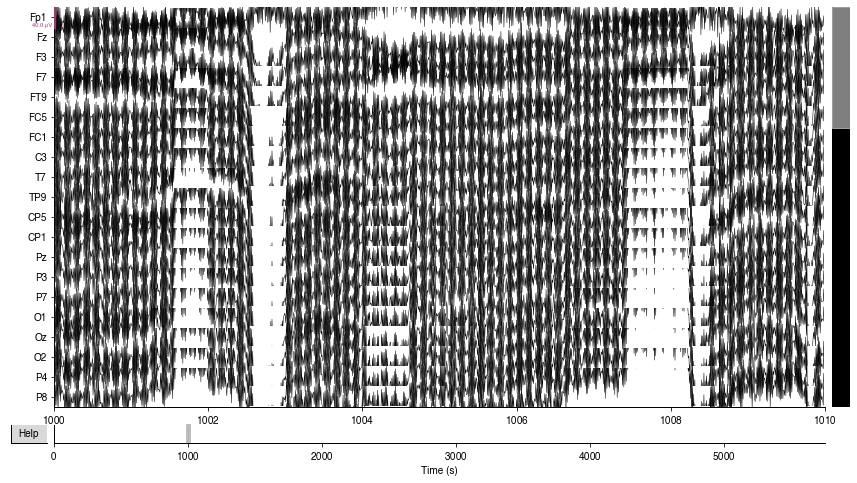

In [5]:
# Let's plot our data to see how it looks
raw.plot(start=1000); # start = start time in seconds
# The semicolon suppresses the output -- for this function it would print twice without

#### Why is `raw.plot()` so ugly?
It's because we haven't preprocessed the data at all. This is what raw data looks like and why EEG is so noisy. So let's do some preprocessing then plot again

**NOTE** : The order of operations for preprocessing is incredibly important. Think PEMDAS but even more cursed. The order I'll take in the notebook is the order we've generally decided on as a lab.

Effective window size : 16.000 (s)


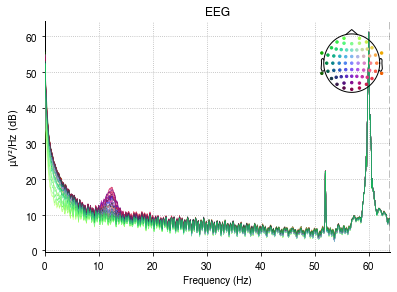

In [6]:
# We can look at the noisiness of the data using raw.plot_psd()
# This plots the intensity of different frequency ranges
raw.plot_psd();
# Notice how there's a huge spike at 60Hz. That is because of 60Hz line noise
# Line noise is caused by the electrical infrastructure of American buildings.
# Other countries can have different frequencies of line noise, but in the USA it's 60Hz.

EEG channel type selected for re-referencing
Applying a custom EEG reference.


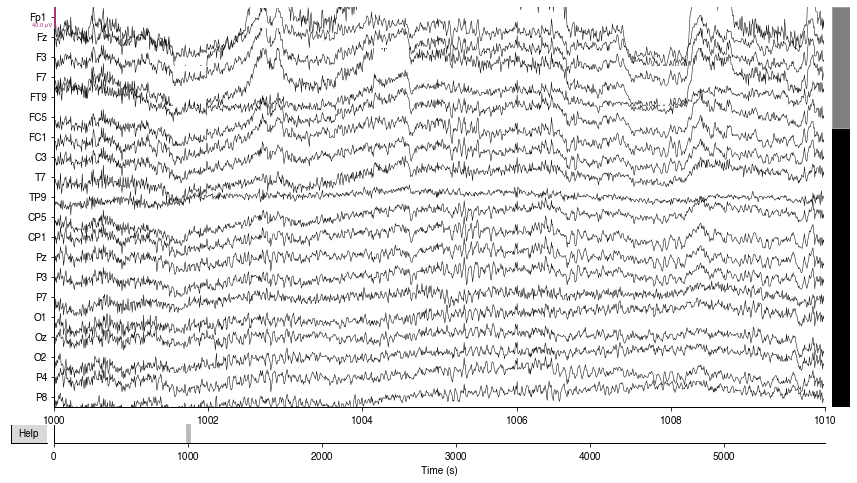

Effective window size : 16.000 (s)


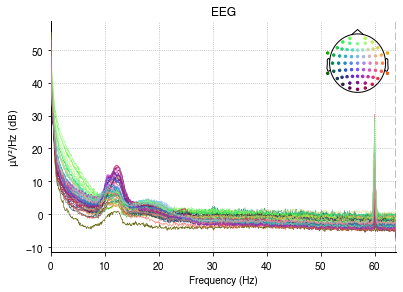

In [7]:
# Step 1: Apply a linked mastoid reference
# A reference subtracts the activity from the "reference" electrode from all the others
# This is the same thing that a ground electrode does, for those who have recorded EEG data IRL
# We are referencing from TP9 and TP10 because these electrodes are relatively neutral
raw.set_eeg_reference(['TP9','TP10'])
raw.plot(start=1000);
raw.plot_psd();

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 sec)



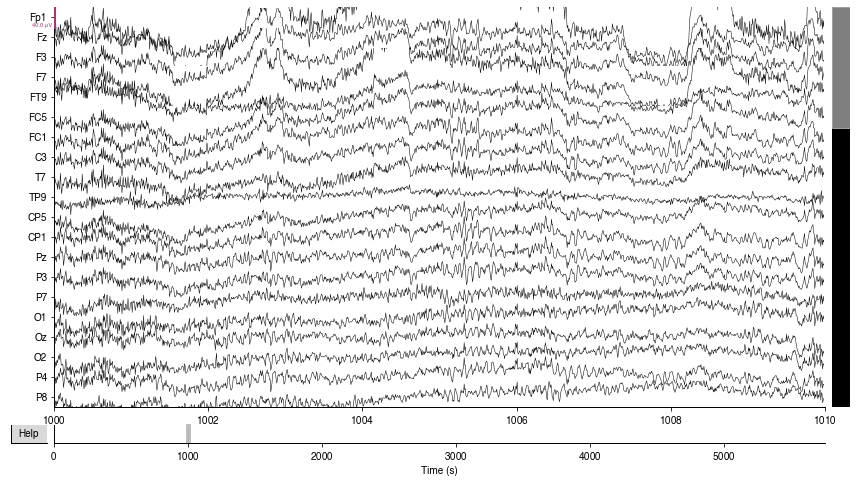

Effective window size : 16.000 (s)


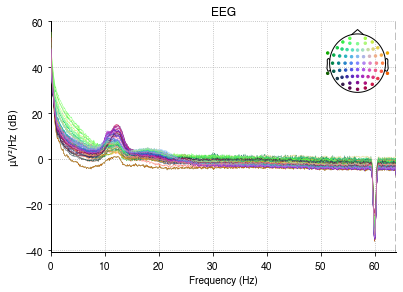

In [8]:
# Step 2: apply a 60Hz notch filter
# A filter selects a range of frequencies and zeroes them out.
# A notch filter is a type of filter that selects one singular frequency and zeroes it.
# Here we are using a notch filter to accomodate for line noise.
raw.notch_filter(60)
raw.plot(start=1000);
raw.plot_psd();

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 sec)



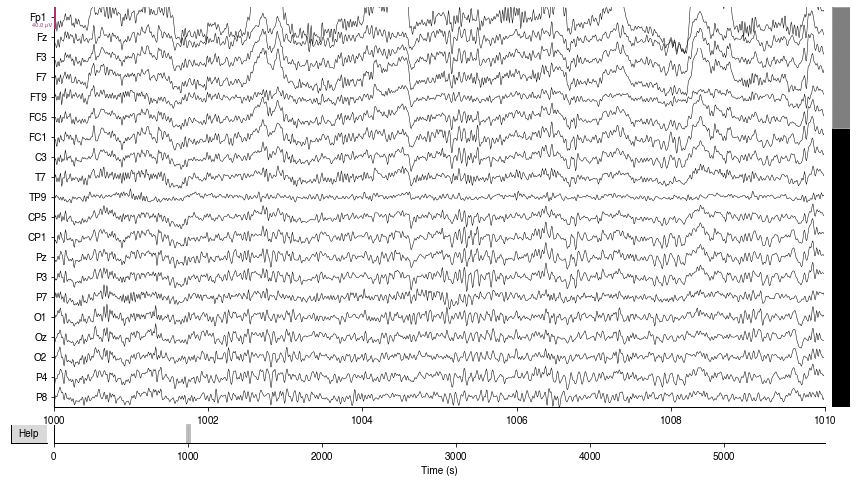

Effective window size : 16.000 (s)


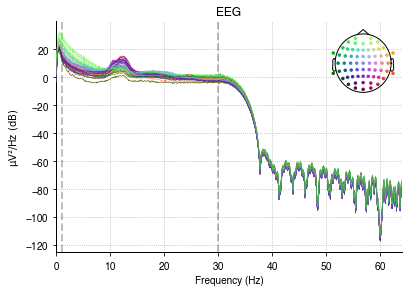

In [9]:
# Step 3: Band-pass filter data from 1 to 30 Hz
# A bandpass filter is another type of filter, where you tell it a frequency range,
# then it zeroes out all frequencies not within that range.
# It's essentially a highpass (only let high frequencies through) and a lowpass (only let low
# frequencies through) filter combined into one.
# The HPF at 1Hz removes slow moving baseline shifts in the data.
# The LPF at 30Hz removes high frequency activity we don't care about (EEG can only accurately
# measure neural activity in lower frequencies)
raw.filter(l_freq=1,h_freq=30)
raw.plot(start=1000);
raw.plot_psd();

## ICA, or stepping outside the notebook
Congrats! You have now done the bare minimum preprocessing (at least for the Hamilton Lab) required to analyze a data set. However, we almost always also do **independent component analysis (ICA)** as well.

ICA is a blind source separation technique that uses some fancy math to separate the EEG activity into a number of components. We are essentially having a computer algorithm guess which activity came from which channel. What this does for us is that it sorts all activity that is repetitive and stereotypical in its response profile into individual components. A lot of non-neural activity we would like removed from the dataset is repetitive and stereotypical, such as muscle activity caused by your eyes blinking (also called EOG). That means ICA is the perfect tool for removing sources of noise (or **artifacts**) such as this.

Unfortunately, the way MNE does ICA is through interactive plotting, which is not well-supported by Jupyter. This means that doing ICA in a Jupyter notebook, while possible, is far from ideal. Luckily, at the beginning of COVID I posted a tutorial on how to run ICA from the Terminal (the preferred method). You can watch that video here: https://utexas.box.com/s/avpfntgjsulq7vgaibjp05oijgqi1s23

If you want to follow along (which I strongly recommend, just change the third line of my iPython terminal's `path` variable to the example dataset I am using in this notebook: `.../Box/lab_intro_notebooks/data/example_raw_data.fif`

In the video, I also talk about annotation (also called artifact rejection), another interactive plotting thing that is not easily accomplished in-notebook. So I will leave an explanation of rejection to that video as well.

### Hamilton Lab order of operations for EEG preprocessing, summarized
1. Load in your raw data.
2. If data was collected across multiple blocks, concatenate using `mne.concatenate_raws()`.
3. If raw isn't downsampled, downsample to 128Hz using `raw.resample(128.)` (you should never have to do this).
4. Apply a linked mastoid reference using `raw.set_eeg_reference(['TP9','TP10'])`. If one of these two channels (TP9/TP10) is a bad channel, you need to interpolate it before you apply a reference using `raw.interpolate_bads(reset_bads=False)`.
5. Notch filter at 60Hz
6. Bandpass filter at 1-30Hz
7. Annotate the raw data, rejecting bad segments and bad channels. This is best accomplished outside Jupyter Notebook.
8. Run ICA using `mne.preprocessing.ICA`, with a number of components equal to the number of non-bad channels (usually 64).
9. Fit the ICA to the raw data using `ica.fit`, then inspect the components using a mixture of `ica.plot_components()`, `ica.plot_sources()`, and `ica.plot_properties()`.
10. Reject bad components using `ica.plot_properties()`.
11. Apply ICA to the raw data using `ica.apply(raw)`.
12. Save the ICA-ed raw data to a .fif file using `raw.save(file_path)`.